## Evaluating EfficientNet and ResNet18 on German Traffic Sign Dataset
### Billy Ryan

### Outline:
- Run final models (EfficientNet and ResNet18) on test set
- Compute basic statistics / visualisation and make inferences
- Observe statistics over all classes to identify trends
- Check common misclassified images in individual models and in both models
- Draw conclusions given findings
- Link to further study and reference other sections of the project

We begin our evaluation with importing functions from previous sections (see Neva and Gracie's work, and my previous files).

In [11]:
# import all required libraries for this evaluation script
import os
import numpy as np
import pandas as pd
from pathlib import Path
import kagglehub
import random
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image, ImageEnhance
import math
from typing import List, Tuple
from collections import Counter
import seaborn as sns
import torch
from torchvision import transforms
from torchvision.models import EfficientNet_B0_Weights
from torchvision.models import efficientnet_b0
from torchvision.models import ResNet50_Weights
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import time

In [12]:
# Download latest version of the dataset and follow procedure in initial file
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

test_df_path =  os.path.join(path, "Test.csv")
test_img_path =  os.path.join(path, "Test")
test_df = pd.read_csv(test_df_path)

class_names = {
    0:"Speed Limit (20Km/hr)", 1:"Speed Limit (30Km/hr)", 
    2:"Speed Limit (50Km/hr)", 3: "Speed Limit (60Km/hr)", 
    4: "Speed Limit (70Km/hr)", 5: "Speed Limit (80Km/hr)",
    6: "End of Speed Limit (80Km/hr)", 7: "Speed Limit (100Km/hr)", 
    8: "Speed Limit (120Km/hr)", 9: "No Passing", 
    10: "No Passing for trucks over 3.5 tons", 11: "Right of way", 
    12: "Priotity Road", 13: "Yeild right of way",
    14: "Stop", 15: "Prohibited for all vehicles",
    16: "Trucks and tractors over 3.5 tons prohibited", 17: "Entery prohibited",
    18: "Danger", 19: "Single curve left",
    20: "Single curve right", 21: "Double curve",
    22: "Rough road", 23: "Slippery road",
    24: "Road narrows", 25: "Construction side ahead",
    26: "Signal lights ahead", 27: "Pedestrian crosswalk ahead",
    28: "Children", 29: "Bicycle crossing",
    30: "Unexpected ice danger", 31: "Wild animal crossing",
    32: "End of restrection", 33: "Mandatory direction of travel right",
    34: "Mandatory direction of travel left", 35: "Mandatory direction of travel ahead",
    36: "Straight or right", 37: "Straight or left",
    38: "Keep right", 39: "Keep left",
    40: "Traffic circle", 41: "End of no passing zone cars",
    42: "End of no passing zone vehicle over 3.5 tons"
}

test_df["ClassName"] = test_df['ClassId'].map(class_names)

In [13]:
# make sure we are in the project directory to call upon mdodels and data correctly
os.chdir("C:/Users/billy/DataScienceToolbox-Project2")
print(os.getcwd())

C:\Users\billy\DataScienceToolbox-Project2


In [14]:
# define normalization constants for imagenet
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# test transform (no augmentation)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

In [15]:
# custom dataset class
class GTSRBDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.root_dir = Path(root_dir)      # <-- convert to Path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.root_dir / row["Path"]   # Path object
        img = Image.open(img_path).convert("RGB")
        label = int(row["ClassId"])

        if self.transform:
            img = self.transform(img)
        return img, label

# create test dataset and dataloader
test_dataset = GTSRBDataset(test_df, root_dir=path, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

In [16]:
NUM_CLASSES = 43

# Load EfficientNet base model
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
base_model = efficientnet_b0(weights=weights)

# remove classifier
base_model.classifier = nn.Identity()

# freeze base model
for param in base_model.parameters():
    param.requires_grad = False

# build the full model
model_eff = nn.Sequential(
    base_model,                # (0)
    nn.Linear(1280, 256),      # (2)
    nn.ReLU(),                 # (3)
    nn.Dropout(0.4),           # (4)
    nn.Linear(256, NUM_CLASSES),  # (5)
    nn.Softmax(dim=1)          # (6)
)

# load the saved weights
state_dict = torch.load("Neva/efficientnet_best.pth", map_location="cpu")
model_eff.load_state_dict(state_dict)

<All keys matched successfully>

In [17]:
model_resnet18 = models.resnet18(weights=None)
model_resnet18.fc = torch.nn.Linear(512, 43)   # example for 43 traffic signs
state_dict_resnet18 = torch.load("Gracie/resnet18_traffic_signs.pth", map_location="cpu")
model_resnet18.load_state_dict(state_dict_resnet18)

<All keys matched successfully>

In [18]:
# require these for later cells
class_names = test_loader.dataset.class_names if hasattr(test_loader.dataset, 'class_names') else class_names
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Below, we finally train our models using the weights that Neva and Gracie found for their respective models. This cell may take some time to run but will output the accuracy and loss of the models.

In [19]:
model_eff.to(device)            
model_resnet18.to(device)
criterion = nn.CrossEntropyLoss()

# Initialize metrics
correct_eff = correct_res = top5_correct_eff = top5_correct_res = total = 0
running_loss_eff = running_loss_res = 0.0
all_labels, all_pred_eff, all_pred_res = [], [], []

model_eff.eval()
model_resnet18.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        batch_size = labels.size(0)
        
        # EfficientNet
        outputs_eff = model_eff(images)
        _, pred_eff = torch.max(outputs_eff, 1)
        _, top5_eff = torch.topk(outputs_eff, 5, dim=1)
        correct_eff += (pred_eff == labels).sum().item()
        top5_correct_eff += (top5_eff == labels.unsqueeze(1)).any(dim=1).sum().item()
        running_loss_eff += criterion(outputs_eff, labels).item() * batch_size
        
        # ResNet18
        outputs_res = model_resnet18(images)
        _, pred_res = torch.max(outputs_res, 1)
        _, top5_res = torch.topk(outputs_res, 5, dim=1)
        correct_res += (pred_res == labels).sum().item()
        top5_correct_res += (top5_res == labels.unsqueeze(1)).any(dim=1).sum().item()
        running_loss_res += criterion(outputs_res, labels).item() * batch_size
        
        # store predictions
        total += batch_size
        all_labels.append(labels.cpu().numpy())
        all_pred_eff.append(pred_eff.cpu().numpy())
        all_pred_res.append(pred_res.cpu().numpy())

# calculate desired metrics (test accuracy, top-5 accuracy, avg loss)
accuracy_eff = 100 * correct_eff / total
top5_accuracy_eff = 100 * top5_correct_eff / total
avg_loss_eff = running_loss_eff / total

accuracy_res = 100 * correct_res / total
top5_accuracy_res = 100 * top5_correct_res / total
avg_loss_res = running_loss_res / total

print(f"Test Accuracy for EfficientNet: {accuracy_eff:.2f}%  | Top-5: {top5_accuracy_eff:.2f}% | Loss: {avg_loss_eff:.4f}")
print(f"Test Accuracy for ResNet18:     {accuracy_res:.2f}%  | Top-5: {top5_accuracy_res:.2f}% | Loss: {avg_loss_res:.4f}")

# need for further analysis
y_true = np.concatenate(all_labels)
y_pred_eff = np.concatenate(all_pred_eff)
y_pred_res = np.concatenate(all_pred_res)

Test Accuracy for EfficientNet: 74.15%  | Top-5: 94.75% | Loss: 3.1044
Test Accuracy for ResNet18:     68.36%  | Top-5: 93.56% | Loss: 1.0516


The results clearly show the performance differences between EfficientNet and ResNet18 on our training data. EfficientNet achieves 74.15% accuracy and a 94.75% top-5 accuracy, whereas ResNet18 attains 68.36% accuracy and 93.56% top-5 accuracy. Top-5 accuracy measures whether the correct label appears among the five most likely predictions [1], which is useful given the number of classes in our dataset and allows us to see how the models rank plausible classes. We see that though EfficientNet has much higher accuracy, both models share similar top-5 accuracy. 

The loss figures are interesting due to the large difference in values. In evaluating the model, we used the standard criterion (CrossEntropyLoss) which penalises both incorrect predictions and low-confidence correct ones, which explains the output values [2]. EfficientNet had a higher loss of 3.1044 compared to ResNet18's loss figure of 1.0566, roughly a third of the value. Therefore, even though EfficientNet achieved a higher accuracy compared to ResNet18, we have that EfficientNet was less confident in its predictions explaining the higher loss figure. From this point, we will be mainly focusing on accuracy as it is a more intuitive metric and can be easily extended.

Now we wish to look at measures such as precision, recall and f1-score. For a more detailed description of said measures, consult Leo's file as he explained them thoroughly; only brief comments will be made here. Precision is simply the proportion of positive classifications that are actually positive. Recall, also known as the true positive rate, is the proportion of actual posities that were successfully classified as positive. F1-score combines both precision and recall into a single formula, where we divide the product of precision and recall by their sum and then finally multiply the result by a factor of 2. 

Below is a function that will output a classification report, which contains our desired metrics, allowing us to compute useful plots and make inferences about the models.

In [20]:
def classification_report_model(model, test_loader, device):
    model.to(device).eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images.to(device))
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())
    
    report_dict = classification_report(all_labels, all_preds, zero_division=0, output_dict=True)
    df_metrics = pd.DataFrame(report_dict).transpose()
    
    return df_metrics, all_labels, all_preds

In [21]:
df_effnet, true_effnet, pred_effnet = classification_report_model(model_eff, test_loader, device)
cm = confusion_matrix(true_effnet, pred_effnet)
print(df_effnet)

              precision    recall  f1-score       support
0              0.625000  0.083333  0.147059     60.000000
1              0.739938  0.663889  0.699854    720.000000
2              0.557100  0.748000  0.638589    750.000000
3              0.620843  0.622222  0.621532    450.000000
4              0.715543  0.739394  0.727273    660.000000
5              0.662669  0.701587  0.681573    630.000000
6              0.876033  0.706667  0.782288    150.000000
7              0.914141  0.804444  0.855792    450.000000
8              0.748889  0.748889  0.748889    450.000000
9              0.870824  0.814583  0.841765    480.000000
10             0.875193  0.860606  0.867838    660.000000
11             0.684760  0.780952  0.729700    420.000000
12             0.985871  0.910145  0.946496    690.000000
13             0.796400  0.983333  0.880050    720.000000
14             0.980695  0.940741  0.960302    270.000000
15             0.939086  0.880952  0.909091    210.000000
16            

In [22]:
df_resnet, true_resnet, pred_resnet = classification_report_model(model_resnet18, test_loader, device)
cm_resnet = confusion_matrix(true_resnet, pred_resnet)
print(df_resnet)

              precision    recall  f1-score      support
0              0.215686  0.183333  0.198198     60.00000
1              0.640648  0.604167  0.621873    720.00000
2              0.479582  0.673333  0.560177    750.00000
3              0.424947  0.446667  0.435536    450.00000
4              0.781302  0.709091  0.743447    660.00000
5              0.620214  0.642857  0.631333    630.00000
6              0.907692  0.786667  0.842857    150.00000
7              0.760976  0.693333  0.725581    450.00000
8              0.710396  0.637778  0.672131    450.00000
9              0.776181  0.787500  0.781799    480.00000
10             0.783824  0.807576  0.795522    660.00000
11             0.762763  0.604762  0.674635    420.00000
12             0.936842  0.902899  0.919557    690.00000
13             0.989130  0.884722  0.934018    720.00000
14             0.972868  0.929630  0.950758    270.00000
15             0.952381  0.952381  0.952381    210.00000
16             0.866197  0.8200

In [64]:
precision_eff_weighted = df_effnet.loc["weighted avg", "precision"]
recall_eff_weighted = df_effnet.loc["weighted avg", "recall"]
f1_eff_weighted = df_effnet.loc["weighted avg", "f1-score"]

precision_res_weighted = df_resnet.loc["weighted avg", "precision"]
recall_res_weighted = df_resnet.loc["weighted avg", "recall"]
f1_res_weighted = df_resnet.loc["weighted avg", "f1-score"]

print(f"EfficientNet - Precision: {precision_eff_weighted:.4f}, Recall: {recall_eff_weighted:.4f}, F1-Score: {f1_eff_weighted:.4f}\n")
print(f"ResNet18 - Precision: {precision_res_weighted:.4f}, Recall: {recall_res_weighted:.4f}, F1-Score: {f1_res_weighted:.4f}")

EfficientNet - Precision: 0.7520, Recall: 0.7415, F1-Score: 0.7391

ResNet18 - Precision: 0.7069, Recall: 0.6836, F1-Score: 0.6884


We will investigate individual class measures later on in this report, for now we divert our attention to the model measures. We see EfficientNet attains higher values in all of the aforementioend measures compared to ResNet18. This provides us good evidence in suggesting that EfficientNet is the superior model of the two. That being said, the values are not particularly high for either models suggesting that both models can be improved upon, or that other models likely handle the data better.
</br>

We now move onto computing the confusion matrix of both models

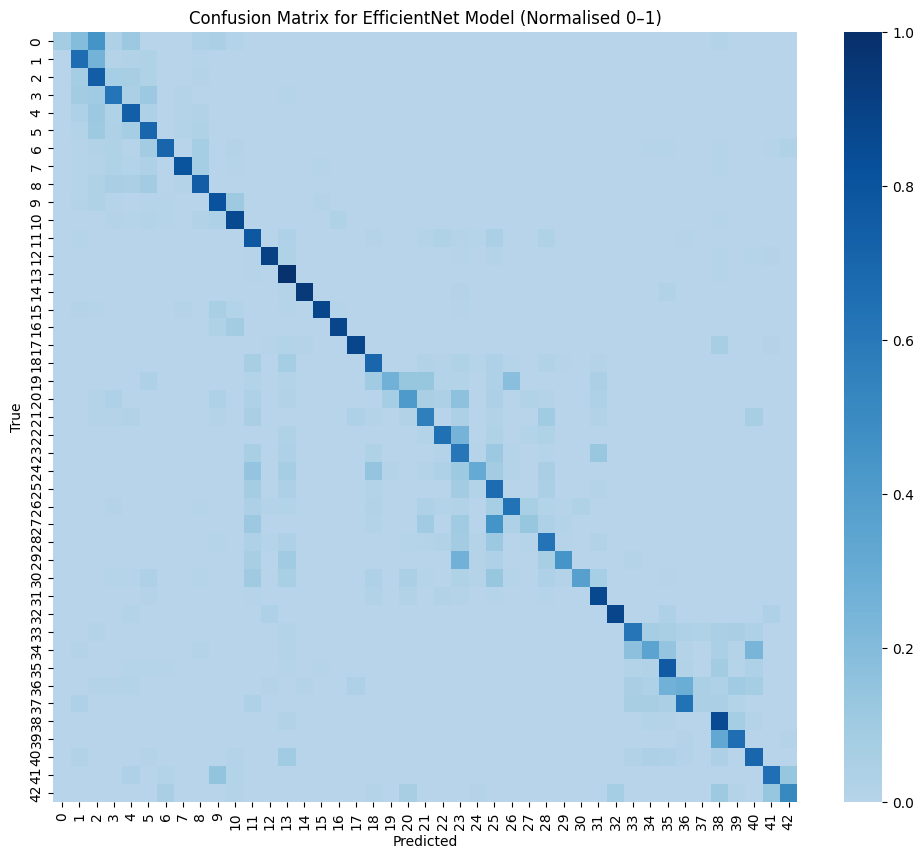

In [24]:
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
blues = plt.cm.Blues
new_blues = LinearSegmentedColormap.from_list("clippedBlues",  blues(np.linspace(0.3, 1, 256)))
plt.figure(figsize=(12, 10))
sns.heatmap(cm_norm, cmap=new_blues, vmin=0, vmax=1)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for EfficientNet Model (Normalised 0–1)")
plt.show()

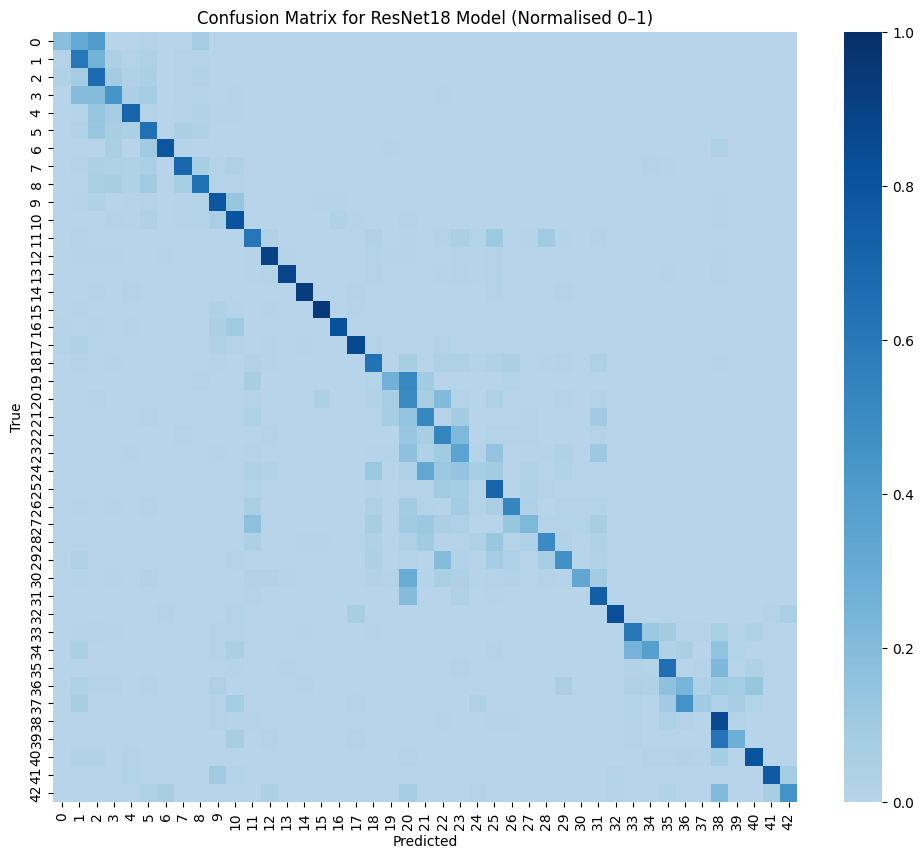

In [25]:
cm_resnet_norm = cm_resnet.astype(float) / cm_resnet.sum(axis=1, keepdims=True)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_resnet_norm, cmap=new_blues, vmin=0, vmax=1)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for ResNet18 Model (Normalised 0–1)")
plt.show()

Comparing both matrices, we see similar outputs. EfficientNet clearly has less variation compared to that of ResNet18, but we can infer that ResNet18 does handle some classes better than EfficientNet. Some classes perform strongly in both models, whilst some classes perform weakly in both models. Truthfully, we can improve on this visualisation by analysing the differences in measures class by class between the two models to get a more quantitative comparison. We will expand on this later.

We are now interested to see common mistakes made by the individual models, and then cross reference to see any similarities.

In [81]:
def get_common_mistakes(cm, top_k=10, class_counts=None):
    mistakes = []
    
    for true_cls in range(cm.shape[0]):
        if class_counts is not None:
            total = class_counts[true_cls]
            if total == 0:
                continue
        
        for pred_cls in range(cm.shape[1]):
            if true_cls != pred_cls and cm[true_cls, pred_cls] > 0:
                count = cm[true_cls, pred_cls]
                
                if class_counts is not None:
                    value = (count / total) * 100
                else:
                    value = count
                    
                mistakes.append((true_cls, pred_cls, value))
    
    mistakes.sort(key=lambda x: x[2], reverse=True)
    return mistakes[:top_k]

In [ ]:
class_counts = np.bincount(y_true)

print("\nMost common misclassifications for EfficientNet:")
for true_cls, pred_cls, count in get_common_mistakes(cm, top_k=10):
    print(f"True {true_cls}, Predicted {pred_cls}: {count} mistakes")

print("\nMost common misclassifications (percentage wise) for EfficientNet:")
for true_cls, pred_cls, pct in get_common_mistakes(cm, top_k=10, class_counts=class_counts):
    print(f"True {true_cls}, Pred {pred_cls}: {pct:.2f}% of class misclassified")


Most common misclassifications for EfficientNet:
True 1, Predicted 2: 183 mistakes
True 4, Predicted 2: 78 mistakes
True 5, Predicted 2: 70 mistakes
True 2, Predicted 1: 56 mistakes
True 38, Predicted 39: 56 mistakes
True 3, Predicted 5: 54 mistakes
True 9, Predicted 10: 54 mistakes
True 2, Predicted 3: 53 mistakes
True 5, Predicted 4: 50 mistakes
True 2, Predicted 4: 48 mistakes

Most common misclassifications (percentage) - EfficientNet:
True 37, Pred 36: 63.33% of class misclassified
True 0, Pred 2: 45.00% of class misclassified
True 27, Pred 25: 45.00% of class misclassified
True 39, Pred 38: 32.22% of class misclassified
True 29, Pred 23: 26.67% of class misclassified
True 36, Pred 35: 26.67% of class misclassified
True 1, Pred 2: 25.42% of class misclassified
True 22, Pred 23: 25.00% of class misclassified
True 34, Pred 40: 24.17% of class misclassified
True 0, Pred 1: 20.00% of class misclassified


In [ ]:
print("\nMost common misclassifications for ResNet18:")
for true_cls, pred_cls, count in get_common_mistakes(cm_resnet, top_k=10):
    print(f"True {true_cls}, Predicted {pred_cls}: {count} mistakes")

print("\nMost common misclassifications (percentage wise) for ResNet18:")
for true_cls, pred_cls, pct in get_common_mistakes(cm_resnet, top_k=10, class_counts=class_counts):
    print(f"True {true_cls}, Pred {pred_cls}: {pct:.2f}% of class misclassified")


Most common misclassifications for ResNet18:
True 1, Predicted 2: 184 mistakes
True 4, Predicted 2: 92 mistakes
True 3, Predicted 1: 89 mistakes
True 3, Predicted 2: 87 mistakes
True 35, Predicted 38: 86 mistakes
True 5, Predicted 2: 82 mistakes
True 2, Predicted 3: 69 mistakes
True 9, Predicted 10: 64 mistakes
True 2, Predicted 1: 63 mistakes
True 39, Predicted 38: 56 mistakes

Most common misclassifications (percentage) for ResNet18:
True 39, Pred 38: 62.22% of class misclassified
True 19, Pred 20: 51.67% of class misclassified
True 37, Pred 36: 45.00% of class misclassified
True 0, Pred 2: 40.00% of class misclassified
True 24, Pred 21: 32.22% of class misclassified
True 0, Pred 1: 31.67% of class misclassified
True 30, Pred 20: 29.33% of class misclassified
True 1, Pred 2: 25.56% of class misclassified
True 34, Pred 33: 25.00% of class misclassified
True 35, Pred 38: 22.05% of class misclassified


In [62]:
def show_worst_classes(df, model_name, n=5):
    worst_recall = (df.iloc[:-3].sort_values("recall").head(n)[["precision", "recall", "f1-score", "support"]].round(3))
    worst_precision = (df.iloc[:-3].sort_values("precision").head(n)[["precision", "recall", "f1-score", "support"]].round(3))
    worst_f1 = (df.iloc[:-3].sort_values("f1-score").head(n)[["precision", "recall", "f1-score", "support"]].round(3))
    print(f"\n{model_name} {n} worst classes (by recall)\n")
    print(worst_recall.to_string())
    print(f"\n{model_name} {n} worst classes (by precision)\n")
    print(worst_precision.to_string())
    print(f"\n{model_name} {n} worst classes (by f1-score)\n")
    print(worst_f1.to_string())

show_worst_classes(df_effnet, "EfficientNet")
show_worst_classes(df_resnet, "ResNet18")


EfficientNet 5 worst classes (by recall)

    precision  recall  f1-score  support
37      0.200   0.050     0.080     60.0
0       0.625   0.083     0.147     60.0
27      0.320   0.133     0.188     60.0
19      0.640   0.267     0.376     60.0
36      0.350   0.292     0.318    120.0

EfficientNet 5 worst classes (by precision)

    precision  recall  f1-score  support
37      0.200   0.050     0.080     60.0
27      0.320   0.133     0.188     60.0
23      0.330   0.607     0.427    150.0
36      0.350   0.292     0.318    120.0
39      0.407   0.656     0.502     90.0

EfficientNet 5 worst classes (by f1-score)

    precision  recall  f1-score  support
37      0.200   0.050     0.080     60.0
0       0.625   0.083     0.147     60.0
27      0.320   0.133     0.188     60.0
36      0.350   0.292     0.318    120.0
19      0.640   0.267     0.376     60.0

ResNet18 5 worst classes (by recall)

    precision  recall  f1-score  support
24      0.111   0.067     0.083     90.0
37     

Recognise common "worst" classes, such as 37 (Straight or left), 27 (Pedestrian crosswalk ahead), 0 (Speed limit 20km/hr) etc., across both models. We can cross reference with the common misclassifications. Talk more in depth here.

In [88]:
both_correct = (y_pred_eff == y_true) & (y_pred_res == y_true)
eff_only     = (y_pred_eff == y_true) & (y_pred_res != y_true)
res_only     = (y_pred_eff != y_true) & (y_pred_res == y_true)
both_wrong   = (y_pred_eff != y_true) & (y_pred_res != y_true)

print(f"Samples both correct:    {both_correct.sum()}")
print(f"EfficientNet only right: {eff_only.sum()}")
print(f"ResNet18 only right:     {res_only.sum()}")
print(f"Both wrong:              {both_wrong.sum()}")

Samples both correct:    7347
EfficientNet only right: 2018
ResNet18 only right:     1287
Both wrong:              1978


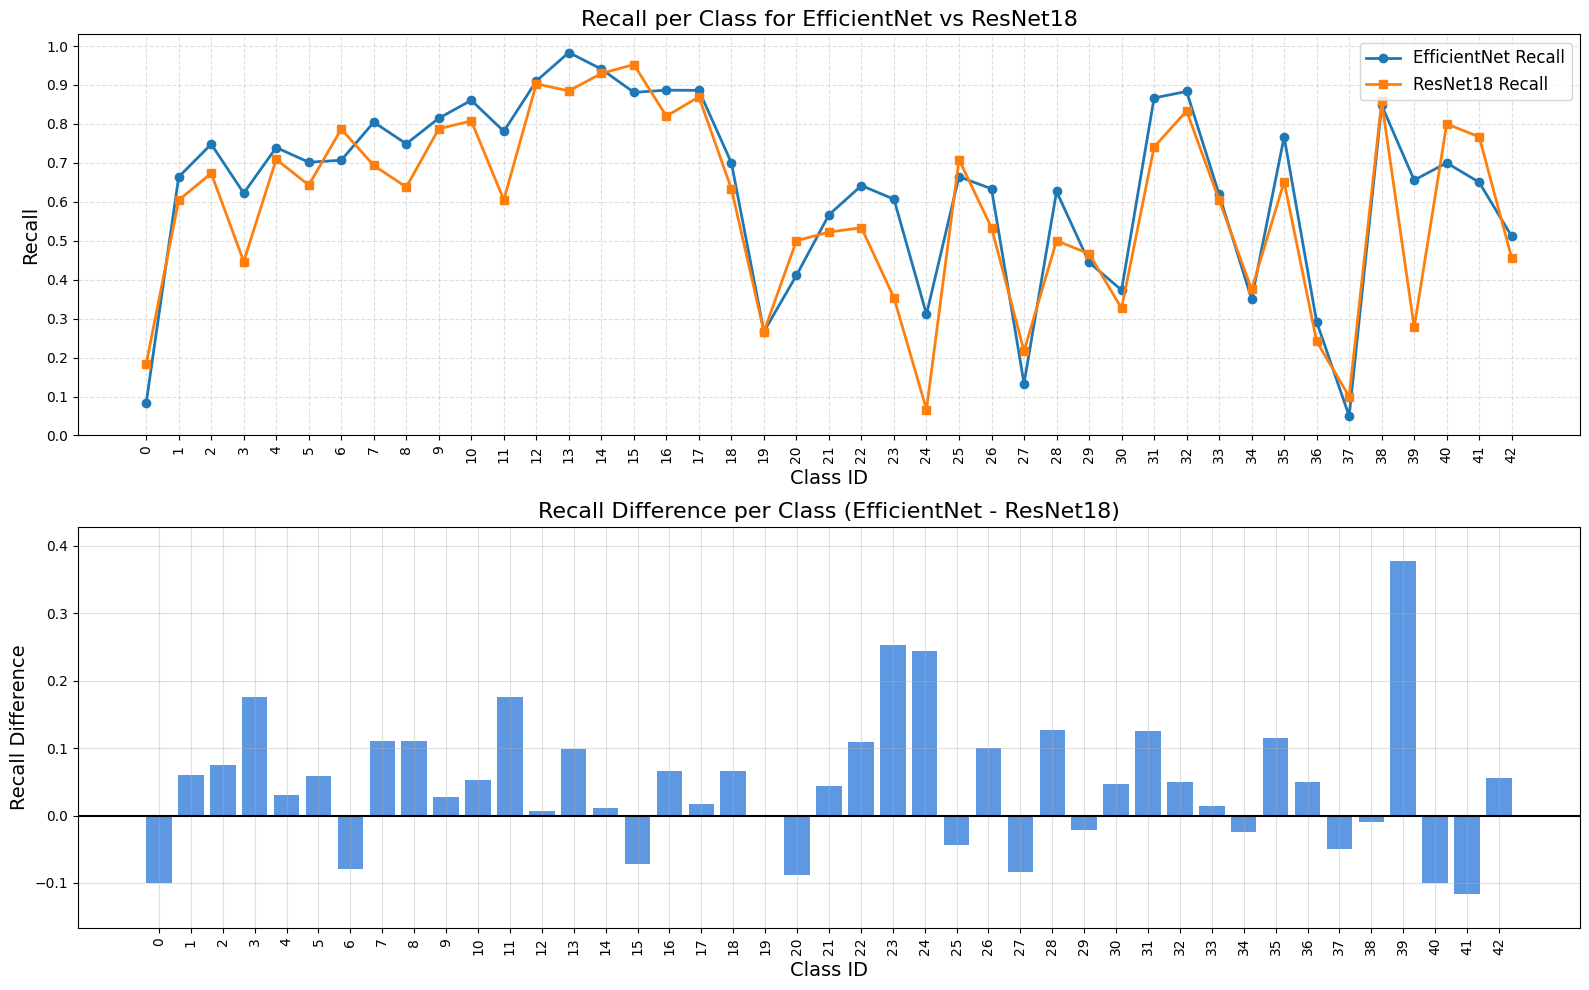

EfficientNet better in recall for 30 classes
ResNet18 better in recall for 12 classes

Top 10 classes with largest recall difference:

Class 39:
Difference: 0.3778
Better model: EfficientNet

Class 23:
Difference: 0.2533
Better model: EfficientNet

Class 24:
Difference: 0.2444
Better model: EfficientNet

Class 11:
Difference: 0.1762
Better model: EfficientNet

Class 3:
Difference: 0.1756
Better model: EfficientNet

Class 28:
Difference: 0.1267
Better model: EfficientNet

Class 31:
Difference: 0.1259
Better model: EfficientNet

Class 41:
Difference: 0.1167
Better model: ResNet18

Class 35:
Difference: 0.1154
Better model: EfficientNet

Class 8:
Difference: 0.1111
Better model: EfficientNet



In [66]:
eff = df_effnet.iloc[:-3] 
res = df_resnet.iloc[:-3]
classes = eff.index.astype(int)

recall_eff = eff["recall"].values   # vector length 43
recall_res = res["recall"].values

diff_recall = recall_eff - recall_res

plt.figure(figsize=(16,10))

# recall plot
plt.subplot(2,1,1)
plt.plot(classes, recall_eff, marker='o', label="EfficientNet Recall", linewidth=2)
plt.plot(classes, recall_res, marker='s', label="ResNet18 Recall", linewidth=2)
plt.title("Recall per Class for EfficientNet vs ResNet18", fontsize=16)
plt.xlabel("Class ID", fontsize=14)
plt.ylabel("Recall", fontsize=14)
plt.xticks(classes, rotation=90)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(fontsize=12)


# diff plot
plt.subplot(2,1,2)
plt.bar(classes, diff_recall, color='#5F98E2')
plt.axhline(0, color="black")
plt.ylim(min(diff_recall) - 0.05, max(diff_recall) + 0.05)
plt.title("Recall Difference per Class (EfficientNet - ResNet18)", fontsize=16)
plt.xlabel("Class ID", fontsize=14)
plt.ylabel("Recall Difference", fontsize=14)
plt.xticks(classes, rotation=90)
plt.grid(True, alpha=0.4)


plt.tight_layout()
plt.show()

# count number of classes where each model is better in recall
eff_better_rec = np.sum(recall_eff > recall_res)
res_better_rec = np.sum(recall_res > recall_eff)

print(f"EfficientNet better in recall for {eff_better_rec} classes")
print(f"ResNet18 better in recall for {res_better_rec} classes\n")

# identify top 10 classes with largest recall difference
abs_diff_recall = np.abs(diff_recall)
top10_rec = np.argsort(abs_diff_recall)[-10:][::-1]

print("Top 10 classes with largest recall difference:\n")
for cls in top10_rec:
    if recall_eff[cls] > recall_res[cls]:
        winner = "EfficientNet"
    else:
        winner = "ResNet18"

    print(f"Class {cls}:")
    print(f"Difference: {abs_diff_recall[cls]:.4f}")
    print(f"Better model: {winner}\n")


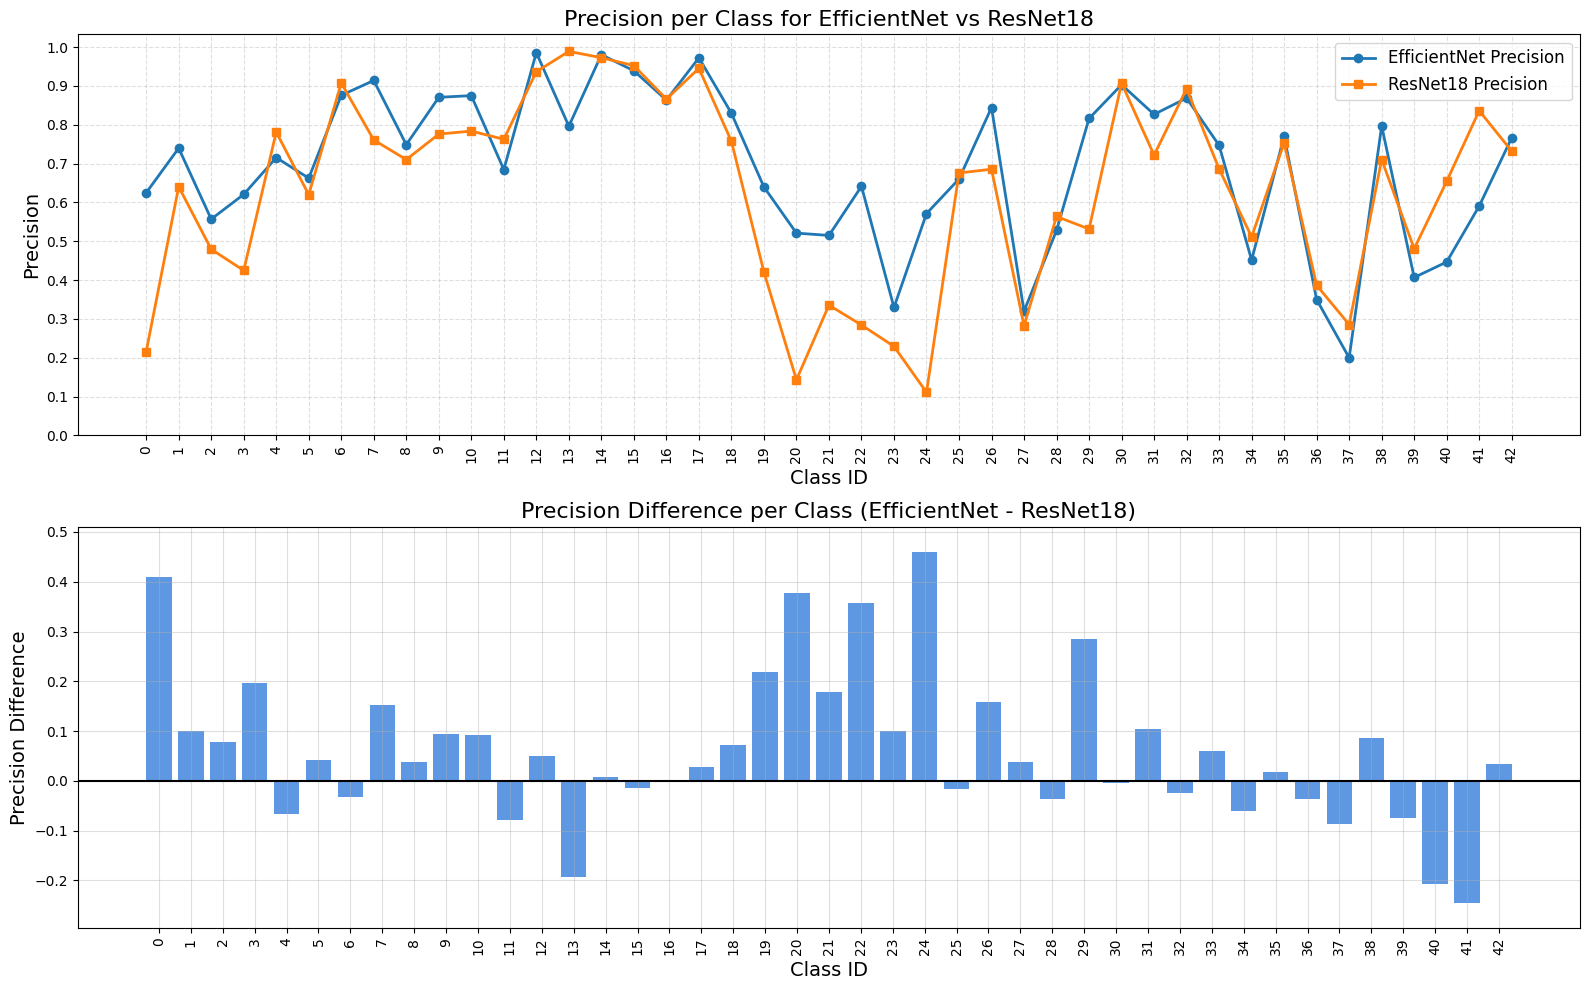

EfficientNet better in precision for 27 classes
ResNet18 better in precision for 16 classes

Top 10 classes with largest precision difference:

Class 24:
Difference: 0.4603
Better model: EfficientNet

Class 0:
Difference: 0.4093
Better model: EfficientNet

Class 20:
Difference: 0.3778
Better model: EfficientNet

Class 22:
Difference: 0.3572
Better model: EfficientNet

Class 29:
Difference: 0.2847
Better model: EfficientNet

Class 41:
Difference: 0.2455
Better model: ResNet18

Class 19:
Difference: 0.2189
Better model: EfficientNet

Class 40:
Difference: 0.2077
Better model: ResNet18

Class 3:
Difference: 0.1959
Better model: EfficientNet

Class 13:
Difference: 0.1927
Better model: ResNet18



In [58]:
precision_eff = eff["precision"].values 
precision_res = res["precision"].values   
 
diff_precision = precision_eff - precision_res

plt.figure(figsize=(16,10))

#precision plot
plt.subplot(2,1,1)
plt.plot(classes, precision_eff, marker='o', label="EfficientNet Precision", linewidth=2)
plt.plot(classes, precision_res, marker='s', label="ResNet18 Precision", linewidth=2)
plt.title("Precision per Class for EfficientNet vs ResNet18", fontsize=16)
plt.xlabel("Class ID", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.xticks(classes, rotation=90)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(fontsize=12)

# diff plot
plt.subplot(2,1,2)
plt.bar(classes, diff_precision, color='#5F98E2')
plt.axhline(0, color="black")
plt.ylim(min(diff_precision) - 0.05, max(diff_precision) + 0.05)
plt.title("Precision Difference per Class (EfficientNet - ResNet18)", fontsize=16)
plt.xlabel("Class ID", fontsize=14)
plt.ylabel("Precision Difference", fontsize=14)
plt.xticks(classes, rotation=90)
plt.grid(True, alpha=0.4)

plt.tight_layout()
plt.show()

# count number of classes where each model is better in precision
eff_better_prec = np.sum(precision_eff > precision_res)
res_better_prec = np.sum(precision_res > precision_eff)

print(f"EfficientNet better in precision for {eff_better_prec} classes")
print(f"ResNet18 better in precision for {res_better_prec} classes\n")

# identify top 10 classes with largest precision difference
abs_diff_precision = np.abs(diff_precision)
top10_prec = np.argsort(abs_diff_precision)[-10:][::-1]

print("Top 10 classes with largest precision difference:\n")
for cls in top10_prec:
    if precision_eff[cls] > precision_res[cls]:
        winner = "EfficientNet"
    else:
        winner = "ResNet18"

    print(f"Class {cls}:")
    print(f"Difference: {abs_diff_precision[cls]:.4f}")
    print(f"Better model: {winner}\n")

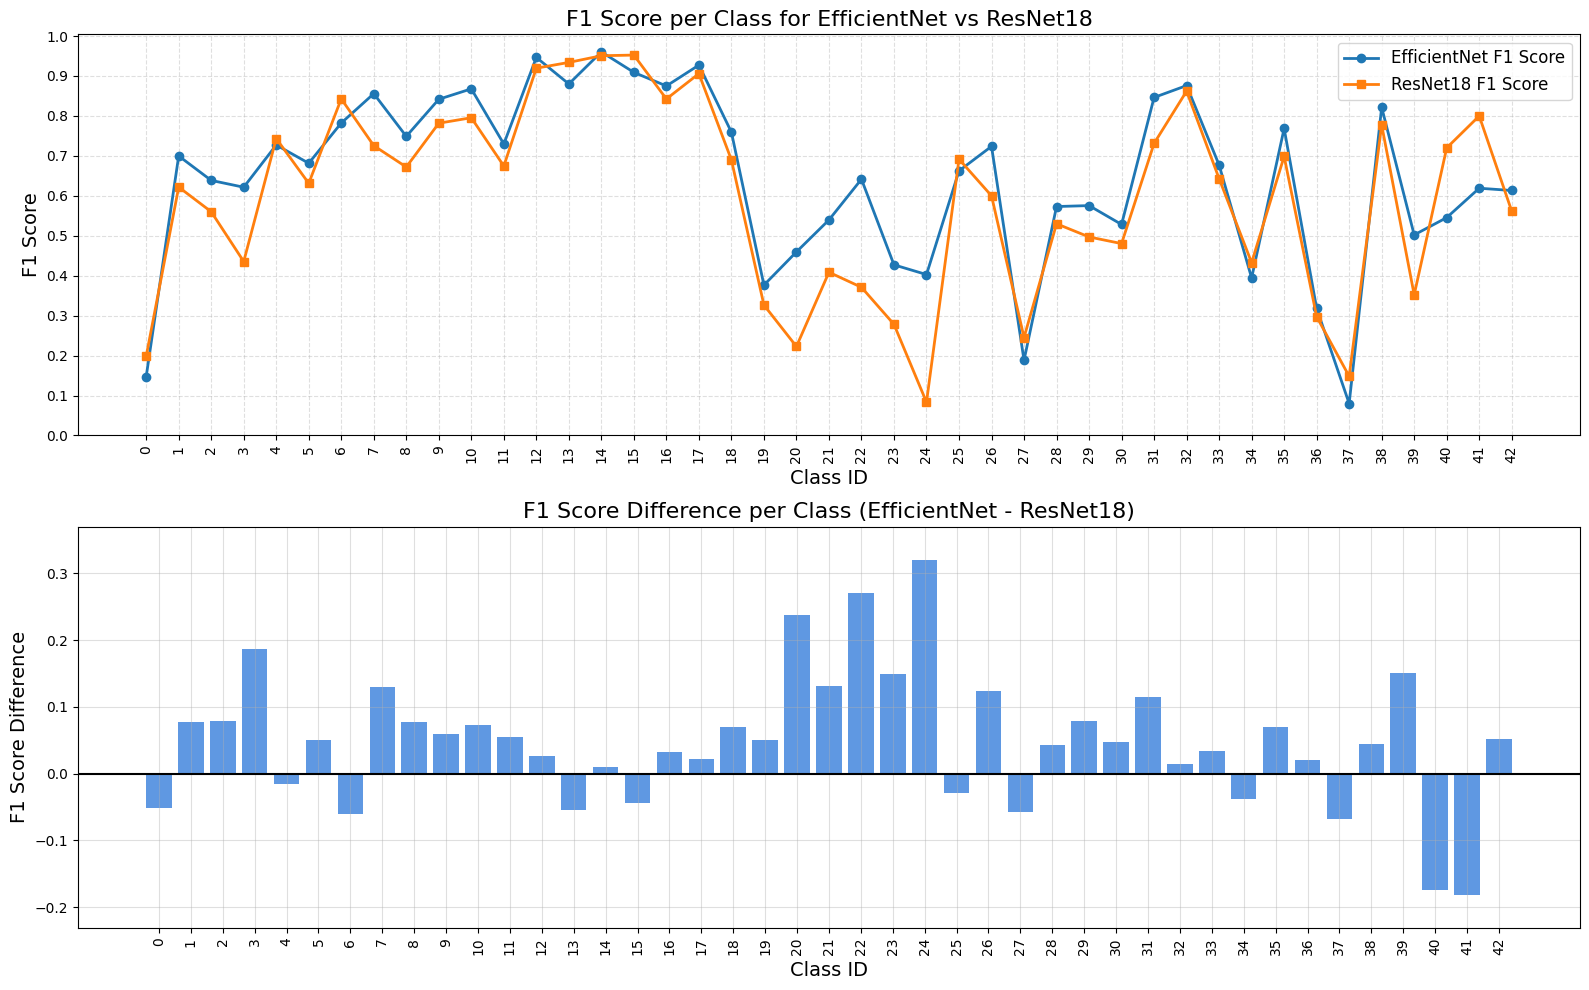

EfficientNet better in F1-score for 32 classes
ResNet18 better in F1-score for 11 classes

Top 10 classes with largest F1-score difference:

Class 24:
Difference: 0.3195
Better model: EfficientNet

Class 22:
Difference: 0.2707
Better model: EfficientNet

Class 20:
Difference: 0.2369
Better model: EfficientNet

Class 3:
Difference: 0.1860
Better model: EfficientNet

Class 41:
Difference: 0.1810
Better model: ResNet18

Class 40:
Difference: 0.1745
Better model: ResNet18

Class 39:
Difference: 0.1500
Better model: EfficientNet

Class 23:
Difference: 0.1490
Better model: EfficientNet

Class 21:
Difference: 0.1310
Better model: EfficientNet

Class 7:
Difference: 0.1302
Better model: EfficientNet



In [59]:
f1_eff = eff["f1-score"].values 
f1_res = res["f1-score"].values   
 
diff_f1 = f1_eff - f1_res

plt.figure(figsize=(16,10))

# f1 plot
plt.subplot(2,1,1)
plt.plot(classes, f1_eff, marker='o', label="EfficientNet F1 Score", linewidth=2)
plt.plot(classes, f1_res, marker='s', label="ResNet18 F1 Score", linewidth=2)
plt.title("F1 Score per Class for EfficientNet vs ResNet18", fontsize=16)
plt.xlabel("Class ID", fontsize=14)
plt.ylabel("F1 Score", fontsize=14)
plt.xticks(classes, rotation=90)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(fontsize=12)

# diff plot
plt.subplot(2,1,2)
plt.bar(classes, diff_f1, color='#5F98E2')
plt.axhline(0, color="black")
plt.ylim(min(diff_f1) - 0.05, max(diff_f1) + 0.05)
plt.title("F1 Score Difference per Class (EfficientNet - ResNet18)", fontsize=16)
plt.xlabel("Class ID", fontsize=14)
plt.ylabel("F1 Score Difference", fontsize=14)
plt.xticks(classes, rotation=90)
plt.grid(True, alpha=0.4)

plt.tight_layout()
plt.show()

# count number of classes where each model is better in f1 score
eff_better_f1 = np.sum(f1_eff > f1_res)
res_better_f1 = np.sum(f1_res > f1_eff)

print(f"EfficientNet better in F1-score for {eff_better_f1} classes")
print(f"ResNet18 better in F1-score for {res_better_f1} classes\n")

# identify top 10 classes with largest F1-score difference
abs_diff_f1 = np.abs(diff_f1)
top10_f1 = np.argsort(abs_diff_f1)[-10:][::-1]

print("Top 10 classes with largest F1-score difference:\n")
for cls in top10_f1:
    if f1_eff[cls] > f1_res[cls]:
        winner = "EfficientNet"
    else:
        winner = "ResNet18"

    print(f"Class {cls}:")
    print(f"Difference: {abs_diff_f1[cls]:.4f}")
    print(f"Better model: {winner}\n")

In [30]:
def show_misclassified(model, loader, device, class_names, max_images=16):
    model.eval()
    misclassified = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            preds = model(images).argmax(1)
            
            # find misclassified samples
            mask = preds != labels
            for img, true_label, pred_label in zip(images[mask], labels[mask], preds[mask]):
                misclassified.append((img.cpu(), true_label.item(), pred_label.item()))
                if len(misclassified) >= max_images:
                    break
            
            if len(misclassified) >= max_images:
                break
    
    if not misclassified:
        print("No misclassifications found!")
        return
    
    n = len(misclassified)
    cols = 4
    rows = (n + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
    axes = axes.flatten() if n > 1 else [axes]
    
    # denormalisation 
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    # plot misclassified images
    for i, (img, true_label, pred_label) in enumerate(misclassified):
        img = (img * std + mean).permute(1, 2, 0).clamp(0, 1)
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"T: {class_names[true_label]}\nP: {class_names[pred_label]}", 
                         fontsize=10)
    
    for i in range(n, len(axes)):
        axes[i].axis("off")
    
    plt.tight_layout()
    plt.show()

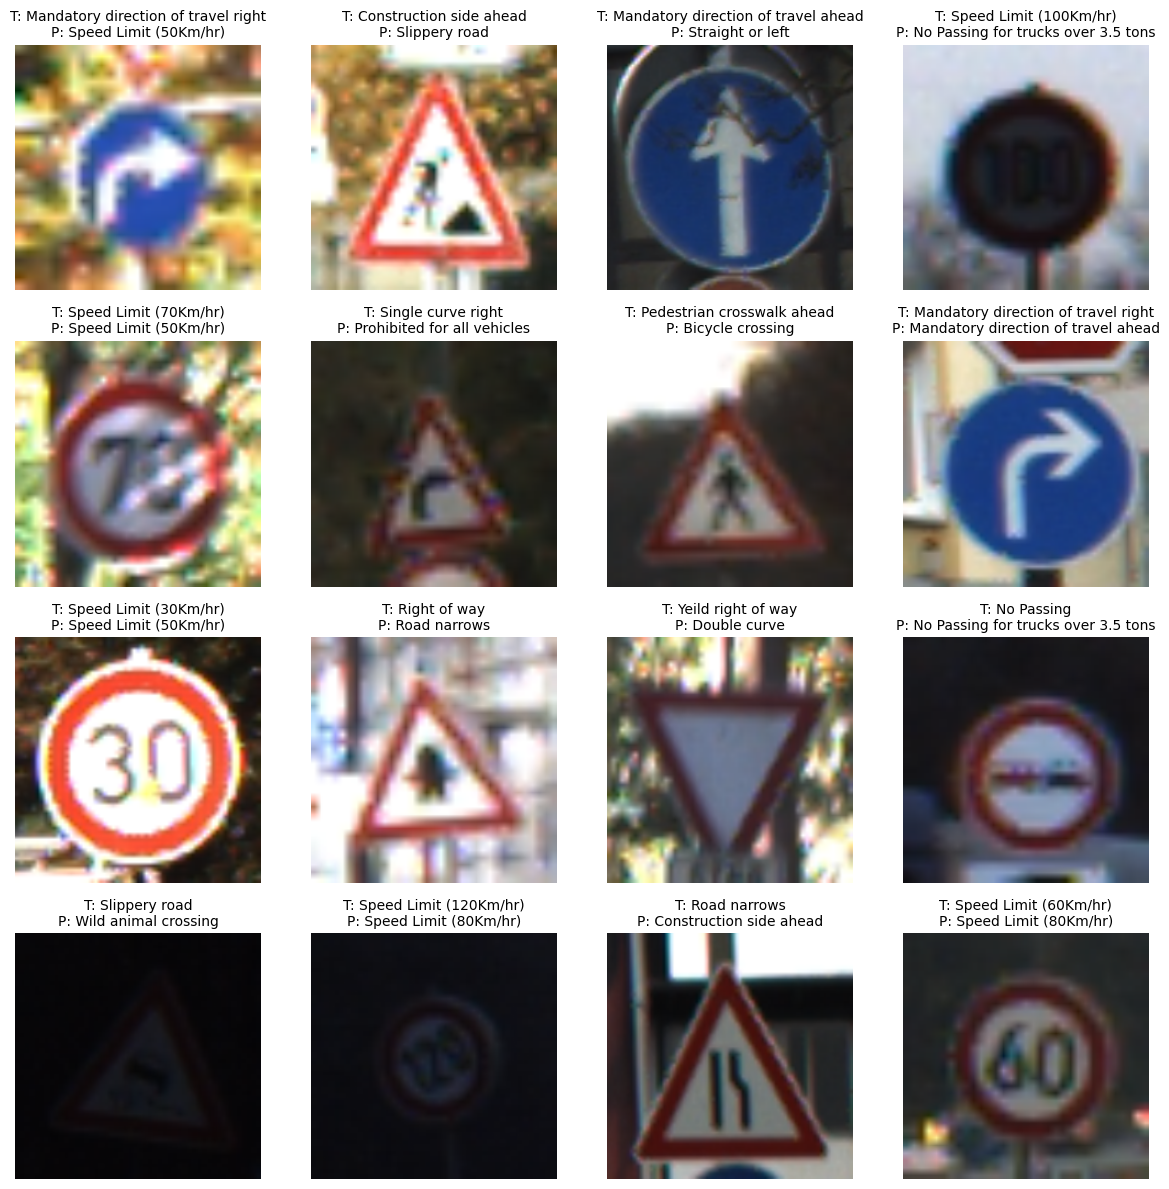

In [31]:
show_misclassified(model_resnet18, test_loader, device, class_names)

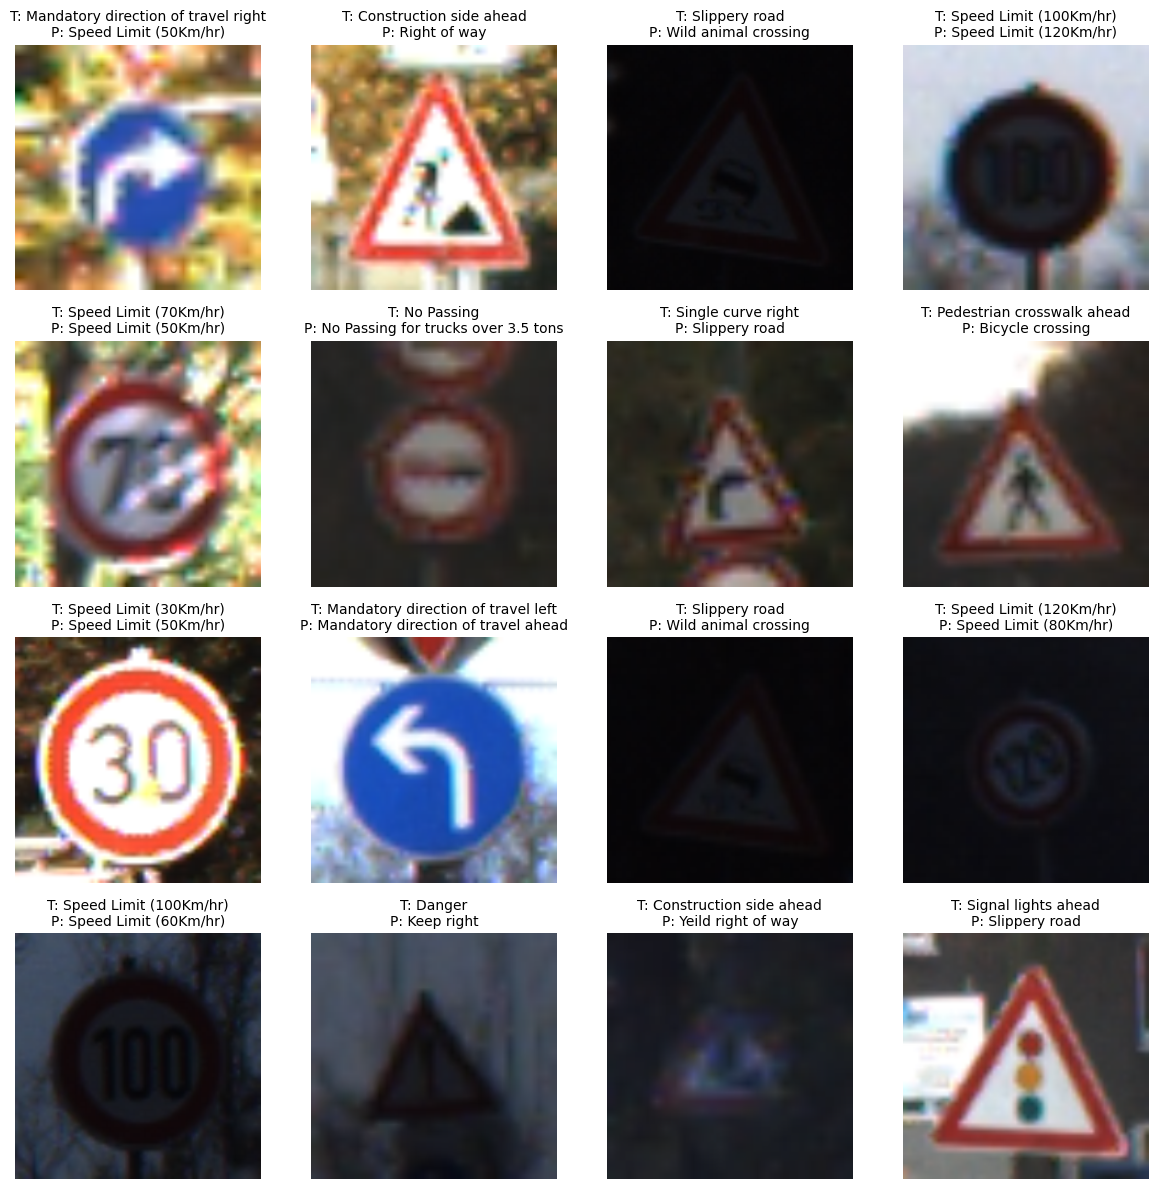

In [32]:
show_misclassified(model_eff, test_loader, device, class_names)

Using the outputs above, and the previous common misclassifications, we can identify common trends more easily. Speed limit signs are often mistaken for other speed limit signs. Directional signs, such as mandatory direction to travel left, are often mistakes for other directional signs. Obviously this is not always true, and there will be misclassifications from a variety of groups, but we can see here common pitfalls that both models succumb to.

References for Eval

[1] https://scikit-learn.org/stable/modules/generated/sklearn.metrics.top_k_accuracy_score.html

[2] https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html